In [382]:
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils_OR.utils_OR import loadHdr

scene_name = 'scene0001_01'
# scene_name = 'scene0002_00'
frame_idx = 4

rendering_path = '/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/DatasetCreation/main_xml'
xml_path = '/newfoundland2/ruizhu/siggraphasia20dataset/code/Routine/scenes/xml'
layout_path = '/newfoundland2/ruizhu/siggraphasia20dataset/layoutMesh'

image_file = Path(rendering_path) / scene_name / ('im_%d.hdr'%frame_idx)
im_hdr = loadHdr(str(image_file))
fig = plt.figure()
ax = fig.gca()
ax.set_aspect("equal")
plt.imshow(im_hdr)
plt.show()

layout_file = Path(layout_path) / scene_name / ('%s_corners.npy'%scene_name)
corners = np.load(layout_file, allow_pickle=True)
print(corners.item())

layout_obj_file = Path(layout_path) / scene_name / 'uv_mapped.obj'
# layout_obj_file = Path(layout_path) / scene_name / ('%s_contour.obj'%scene_name)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'light_ctr': array([[5.9201, 3.8378, 3.    , 0.4   ]]), 'type': ['w', 'd', 'w'], 'coords': [array([[2.227 , 7.108 , 0.7257],
       [2.76  , 8.2028, 0.7257],
       [2.76  , 8.2028, 2.1603],
       [2.227 , 7.108 , 2.1603]]), array([[1.4655, 5.5439, 0.    ],
       [2.1127, 6.8734, 0.    ],
       [2.1127, 6.8734, 2.1603],
       [1.4655, 5.5439, 2.1603]]), array([[0.8564, 4.2926, 0.7257],
       [1.3513, 5.3092, 0.7257],
       [1.3513, 5.3092, 2.1603],
       [0.8564, 4.2926, 2.1603]])]}


In [383]:
from utils_OR.utils_OR_mesh import *
mesh = load_OR_mesh(layout_obj_file)
# mesh = mesh.dump()[0]
mesh = remove_top_down_faces(mesh)
v = np.array(mesh.vertices)
e = mesh.edges

%matplotlib widget
from utils.utils_rui import vis_axis
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
# vis_axis(ax)
v_pairs = v_pairs_from_v3d_e(v, e)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])

v_2d, e_2d = mesh_to_contour(mesh)
fig = plt.figure()
ax = fig.gca()
ax.set_aspect("equal")
v_pairs = v_pairs_from_v2d_e(v_2d, e_2d)
for v_pair in v_pairs:
    ax.plot(v_pair[0], v_pair[1])

v_skeleton, e_skeleton = mesh_to_skeleton(mesh)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
# vis_axis(ax)
v_pairs = v_pairs_from_v3d_e(v_skeleton, e_skeleton)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [384]:
transformFile = Path(xml_path) / scene_name / 'transform.dat'
# load transformations # writeShapeToXML.py L588
with open(str(transformFile), 'rb') as fIn:
    transforms = pickle.load(fIn )

transforms_layout = transforms[0]

v_skeleton_transform = transform_v(v_skeleton, transforms_layout)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
v_pairs = v_pairs_from_v3d_e(v_skeleton_transform, e_skeleton)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])
ax.view_init(elev=-71, azim=-65)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [385]:
main_xml_file = Path(xml_path) / scene_name / 'main.xml'
import xml.etree.ElementTree as et
tree = et.parse(str(main_xml_file)) # L202 of sampleCameraPoseFromScanNet.py
root  = tree.getroot()
sensors = root.findall('sensor')
assert len(sensors)==1
sensor = sensors[0]

film = sensor.findall('film')[0]
integers = film.findall('integer')
for integer in integers:
    if integer.get('name' ) == 'width':
        width = int(integer.get('value'))
    if integer.get('name' ) == 'height':
        height = int(integer.get('value'))
fov_entry = sensor.findall('float')[0]
assert fov_entry.get('name') == 'fov'
fov = float(fov_entry.get('value'))
f_px = width / 2. / np.tan(fov / 180. * np.pi / 2.)
cam_K = np.array([[f_px, 0., width/2.], [0., f_px, height/2.], [0., 0., 1.]])

In [386]:
import os.path as osp
camFile = Path(xml_path) / scene_name / 'cam.txt'
assert osp.isfile(str(camFile))
with open(str(camFile), 'r') as camIn:
#     camNum = int(camIn.readline().strip() )
    cam_data = camIn.read().splitlines()
cam_num = int(cam_data[0])
cam_params = np.array([x.split(' ') for x in cam_data[1:]]).astype(np.float)
assert cam_params.shape[0] == cam_num * 3
cam_params = np.split(cam_params, cam_num, axis=0) # [[origin, lookat, up], ...]

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

cam_param = cam_params[frame_idx-1]
origin, lookat, up = np.split(cam_param.T, 3, axis=1)
at_vector = lookat - origin
assert np.amax(np.abs(np.dot(at_vector.flatten(), up.flatten()))) < 1e-3 # two vector should be perpendicular
def normalize(x):
    return x / np.linalg.norm(x)
zaxis = normalize(lookat - origin)
# xaxis = normalize(np.cross(up.flatten(), zaxis.flatten()).reshape(3, 1))
xaxis = normalize(np.cross(up.T, zaxis.T).T)
yaxis = np.cross(zaxis.T, xaxis.T).T
transformation = np.hstack([xaxis, yaxis, zaxis, np.zeros((3, 1))])
transformation = np.vstack([transformation, \
                            np.array([-np.dot(xaxis.flatten(), origin.flatten()), -np.dot(yaxis.flatten(), origin.flatten()), -np.dot(zaxis.flatten(), origin.flatten()), 1]).reshape(1, 4)])
print(transformation)

[[-0.8136 -0.1869 -0.5505  0.    ]
 [ 0.0002  0.9468 -0.3217  0.    ]
 [ 0.5814 -0.2619 -0.7703  0.    ]
 [ 0.5831  0.4566  3.4172  1.    ]]


/home/ruizhu/anaconda3/envs/Total3D/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


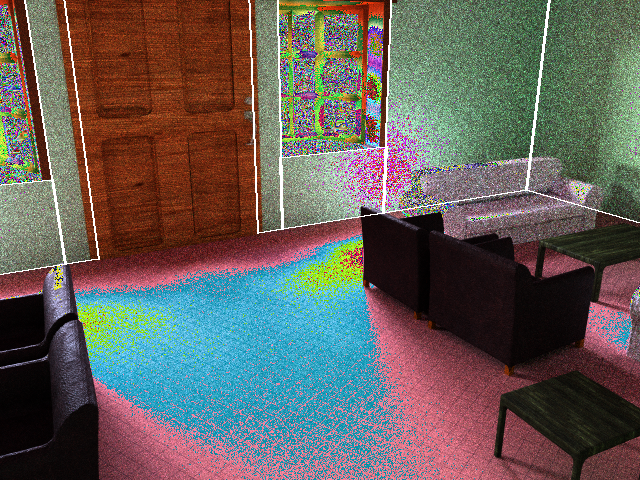

In [387]:
cam_R = np.eye(3, dtype=np.float)
cam_t = np.zeros((3, 1), dtype=np.float)
cam_identity_homo = np.vstack([np.hstack([cam_R, cam_t]), np.array([0., 0., 0., 1.]).reshape(1, 4)])
def project_v(v, cam_R, cam_t, cam_K):
    v_transformed = cam_R @ v.T + cam_t
#     print(v_transformed[2:3, :])
    v_transformed = v_transformed * (v_transformed[2:3, :] > 0.)
    p = cam_K @ v_transformed
    return np.vstack([p[0, :]/p[2, :], p[1, :]/p[2, :]]).T

def project_v_homo(v, cam_transformation4x4, cam_K):
    # https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/img30.gif
    # https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/EPSRC_SSAZ/node3.html
    v_homo = np.hstack([v, np.ones((v.shape[0], 1))])
    cam_K_homo = np.hstack([cam_K, np.zeros((3, 1))])
#     v_transformed = cam_R @ v.T + cam_t

    v_transformed = cam_transformation4x4 @ v_homo.T
    v_transformed_nonhomo = np.vstack([v_transformed[0, :]/v_transformed[3, :], v_transformed[1, :]/v_transformed[3, :], v_transformed[2, :]/v_transformed[3, :]])
#     print(v_transformed.shape, v_transformed_nonhomo.shape)
    v_transformed = v_transformed * (v_transformed_nonhomo[2:3, :] > 0.)
    p = cam_K_homo @ v_transformed
    return np.vstack([p[0, :]/p[2, :], p[1, :]/p[2, :]]).T

# v_proj_1 = project_v(v_skeleton_transform, cam_R, cam_t, cam_K)
# # print(v_proj)
# v_proj_2 = project_v_homo(v_skeleton_transform, cam_transformation_homo, cam_K)
# # print(v_proj)
# assert np.array_equal(v_proj_1, v_proj_2)

# shoube be the same:
# v_proj = project_v_homo(v_skeleton_transform, cam_identity_homo, cam_K)
v_proj = project_v(v_skeleton_transform, cam_R, cam_t, cam_K)

# v_proj = project_v_homo(v_skeleton_transform, transformation, cam_K)
R_c = np.hstack([xaxis, yaxis, zaxis])
R_c = np.linalg.inv(R_c)
t_c = - R_c @ origin
v_proj = project_v(v_skeleton_transform, R_c, t_c, cam_K)
v_proj = np.array([width, height]).reshape((-1, 2)) - v_proj

from PIL import Image, ImageDraw, ImageFont
img_map = Image.fromarray((im_hdr*255.).astype(np.uint8))
draw = ImageDraw.Draw(img_map)
    
v_tuples = v_xytuple_from_v2d_e(v_proj, e_skeleton) # [(x1y1, x2y2), ...]
v_tuples = [x for x in v_tuples if in_frame(x[0], width, height) or in_frame(x[1], width, height)]

for v_tuple in v_tuples:
    draw.line([tuple(v_tuple[0]), tuple(v_tuple[1])], width=2)
# ,
#       fill=(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)), width=width)
img_map

In [388]:
img_map.size

(640, 480)

In [355]:
cam_K

array([[433.4031,   0.    , 320.    ],
       [  0.    , 433.4031, 240.    ],
       [  0.    ,   0.    ,   1.    ]])

In [348]:
R_c @ origin + t_c

array([[0.],
       [0.],
       [0.]])

In [352]:
R_c @ lookat + t_c

array([[-0.    ],
       [-0.    ],
       [ 1.0009]])

In [389]:
from utils.utils_rui import Arrow3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_proj_type('ortho')
ax.set_aspect("auto")
v_pairs = v_pairs_from_v3d_e(v_skeleton_transform, e_skeleton)
for v_pair in v_pairs:
    ax.plot3D(v_pair[0], v_pair[1], v_pair[2])
ax.view_init(elev=-36, azim=89)
vis_axis(ax)

from utils.utils_rui import vis_axis_xyz
vis_axis_xyz(ax, xaxis.flatten(), yaxis.flatten(), zaxis.flatten(), origin.flatten(), suffix='_c')

a = Arrow3D([origin[0][0], lookat[0][0]*2-origin[0][0]], [origin[1][0], lookat[1][0]*2-origin[1][0]], [origin[2][0], lookat[2][0]*2-origin[2][0]], mutation_scale=20,
                lw=1, arrowstyle="->", color="k")
# a = Arrow3D([0., 1.,], [0., 1.,], [0., 1.,], mutation_scale=20,
#                 lw=1, arrowstyle="->", color="k")
ax.add_artist(a)
a_up = Arrow3D([origin[0][0], origin[0][0]+up[0][0]], [origin[1][0], origin[1][0]+up[1][0]], [origin[2][0], origin[2][0]+up[2][0]], mutation_scale=20,
                lw=1, arrowstyle="->", color="r")
ax.add_artist(a_up)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [278]:
at_vector = lookat - origin


-8.600000000005966e-05

In [259]:
origin, lookat[1]

(array([[0.664],
        [0.527],
        [4.281]]),
 array([0.224]))

[array([[ 0.664,  0.527,  4.281],
        [ 0.238,  0.224,  3.428],
        [-0.135,  0.953, -0.271]]),
 array([[ 3.982,  0.4  , -0.147],
        [ 3.037,  0.223, -0.42 ],
        [-0.17 ,  0.984, -0.049]]),
 array([[ 2.52 ,  0.583,  2.454],
        [ 1.672,  0.426,  1.946],
        [-0.134,  0.988, -0.08 ]]),
 array([[ 2.441,  0.667,  2.413],
        [ 1.89 ,  0.345,  1.642],
        [-0.187,  0.947, -0.262]]),
 array([[ 3.697,  0.562, -2.   ],
        [ 2.842,  0.181, -1.649],
        [-0.353,  0.924,  0.144]]),
 array([[-2.652,  0.353,  2.687],
        [-2.046,  0.028,  1.962],
        [ 0.208,  0.946, -0.249]]),
 array([[1.883, 0.449, 4.056],
        [1.528, 0.598, 3.133],
        [0.053, 0.989, 0.139]]),
 array([[2.601, 0.32 , 4.468],
        [1.993, 0.553, 3.709],
        [0.146, 0.972, 0.182]]),
 array([[ 2.179,  0.344, -3.055],
        [ 1.831,  0.107, -2.148],
        [-0.085,  0.972,  0.221]]),
 array([[ 1.942,  0.65 , -2.618],
        [ 1.478,  0.098, -1.925],
        [-0.30

In [102]:
v_pairs = v_pairs_from_v3d_e(v_skeleton_transform, e_skeleton)


In [48]:
import trimesh
mesh = trimesh.load_mesh(str(layout_obj_file), force='mesh', skip_texture=True)

mesh.dump()[0].vertices

TrackedArray([[ 5.887235,  2.168654,  3.      ],
              [ 6.749932,  1.737305,  3.      ],
              [ 3.711737, 10.157982,  3.      ],
              [ 8.231522,  5.919512,  3.      ],
              [ 5.868481,  0.199454,  3.      ],
              [ 4.55568 , -0.156878,  3.      ],
              [ 5.0808  ,  0.518277,  3.      ],
              [ 8.512836,  7.551136,  3.      ],
              [-0.095384,  2.337443,  3.      ],
              [ 7.237544,  4.775501,  3.      ],
              [ 7.762664,  6.200827,  3.      ],
              [ 7.537612,  4.644221,  3.      ]])

In [42]:

v_pairs

[(array([7.237544, 3.711737]), array([ 4.775501, 10.157982]), array([3., 3.])),
 (array([ 3.711737, -0.095384]),
  array([10.157982,  2.337443]),
  array([3., 3.])),
 (array([-0.095384,  7.237544]), array([2.337443, 4.775501]), array([3., 3.])),
 (array([3.711737, 7.762664]), array([10.157982,  6.200827]), array([3., 3.])),
 (array([7.762664, 8.512836]), array([6.200827, 7.551136]), array([3., 3.])),
 (array([8.512836, 3.711737]), array([ 7.551136, 10.157982]), array([3., 3.])),
 (array([7.237544, 7.762664]), array([4.775501, 6.200827]), array([3., 3.])),
 (array([7.762664, 3.711737]), array([ 6.200827, 10.157982]), array([3., 3.])),
 (array([3.711737, 7.237544]), array([10.157982,  4.775501]), array([3., 3.])),
 (array([7.762664, 8.231522]), array([6.200827, 5.919512]), array([3., 3.])),
 (array([8.231522, 8.512836]), array([5.919512, 7.551136]), array([3., 3.])),
 (array([8.512836, 7.762664]), array([7.551136, 6.200827]), array([3., 3.])),
 (array([8.231522, 7.762664]), array([5.9195

In [33]:
mesh.edges

array([[ 9,  2],
       [ 2,  8],
       [ 8,  9],
       [ 2, 10],
       [10,  7],
       [ 7,  2],
       [ 9, 10],
       [10,  2],
       [ 2,  9],
       [10,  3],
       [ 3,  7],
       [ 7, 10],
       [ 3, 10],
       [10,  9],
       [ 9,  3],
       [ 1,  0],
       [ 0,  4],
       [ 4,  1],
       [ 0,  9],
       [ 9,  8],
       [ 8,  0],
       [11,  3],
       [ 3,  9],
       [ 9, 11],
       [ 3, 11],
       [11,  1],
       [ 1,  3],
       [ 0, 11],
       [11,  9],
       [ 9,  0],
       [11,  0],
       [ 0,  1],
       [ 1, 11],
       [ 6,  5],
       [ 5,  4],
       [ 4,  6],
       [ 0,  6],
       [ 6,  4],
       [ 4,  0],
       [ 5,  6],
       [ 6,  8],
       [ 8,  5],
       [ 6,  0],
       [ 0,  8],
       [ 8,  6],
       [21, 14],
       [14, 20],
       [20, 21],
       [14, 22],
       [22, 19],
       [19, 14],
       [21, 22],
       [22, 14],
       [14, 21],
       [22, 15],
       [15, 19],
       [19, 22],
       [15, 22],
       [22, 21

array([[ 5.887235,  2.168654,  3.      ],
       [ 6.749932,  1.737305,  3.      ],
       [ 3.711737, 10.157982,  3.      ],
       [ 8.231522,  5.919512,  3.      ],
       [ 5.868481,  0.199454,  3.      ],
       [ 4.55568 , -0.156878,  3.      ],
       [ 5.0808  ,  0.518277,  3.      ],
       [ 8.512836,  7.551136,  3.      ],
       [-0.095384,  2.337443,  3.      ],
       [ 7.237544,  4.775501,  3.      ],
       [ 7.762664,  6.200827,  3.      ],
       [ 7.537612,  4.644221,  3.      ],
       [ 5.887235,  2.168654,  0.      ],
       [ 6.749932,  1.737306,  0.      ],
       [ 3.711737, 10.157982,  0.      ],
       [ 8.231522,  5.919512,  0.      ],
       [ 5.868481,  0.199454,  0.      ],
       [ 4.55568 , -0.156878, -0.      ],
       [ 5.0808  ,  0.518277,  0.      ],
       [ 8.512836,  7.551136,  0.      ],
       [-0.095384,  2.337443,  0.      ],
       [ 7.237544,  4.775501,  0.      ],
       [ 7.762664,  6.200827,  0.      ],
       [ 7.537612,  4.644221,  0. 

In [3]:
import pymesh # https://pymesh.readthedocs.io/en/latest/installation.html
mesh = pymesh.load_mesh(layout_obj_file)

AttributeError: module 'pymesh' has no attribute 'load_mesh'